# Lecture 18: 2023-04-04 Word Embeddings and Sequence Models

## Lecture Overview

* Word Embeddings (Word2Vec, GLoVe, FastText, and ELMo)
* Sequence Models (RNNs, LSTMs, and BiLSTMs)

## Word Embeddings

### Static Word Embeddings

1. Lack of contextual representations: Static embeddings assign a single vector representation to each word, which fails to capture the different meanings or senses of a word when used in different contexts.

2. Polysemy: Since static embeddings provide a single representation for each word, they cannot differentiate between multiple senses of words (words with multiple meanings). This can lead to misinterpretation and decreased performance in NLP tasks.

3. Limited vocabulary and out-of-vocabulary (OOV) words: Static embeddings are generated from a fixed vocabulary. Words not present in the training corpus are treated as out-of-vocabulary words, and the model struggles to provide meaningful representations for them.

4. Suboptimal handling of phrases and idiomatic expressions: Static word embeddings often struggle to capture the meanings of phrases or idiomatic expressions, as they are designed to work with individual words rather than multi-word units.

5. Static in nature: Once trained, the word embeddings remain static and do not evolve or adapt to new contexts or updates in language use. This can limit their performance in applications that require up-to-date language understanding.

6. No explicit morphological information: Static word embeddings do not explicitly account for morphological information, such as prefixes, suffixes, or inflections, which can be important for understanding word meanings.

### Dynamic or Contextual Word Embeddings

1. ELMo: Embeddings from Language Models
2. BERT: Bidirectional Encoder Representations from Transformers
3. GPT: Generative Pre-Training


## Caveat: Large Language Models BIG-Bench

* BIG-Bench: A benchmark for general-purpose language models [REPO](https://github.com/google/BIG-bench)



## Sequence data

* Sequence data is data that is ordered in some way. For example, a sequence of words in a sentence, a sequence of characters in a word, a sequence of pixels in an image, a sequence of notes in a song, a sequence of frames in a video, and so on.

* Unlike Bag-of-Words models, sequence models can take into account the order of the words in a sentence. This makes them ideal for tasks such as machine translation, speech recognition, and text summarization.

* We will follow the standard conventions and model sequence data as follows:

$$x^{(i)} = (x_1^{(i)}, x_2^{(i)}, \ldots, x_T^{(i)})$$

Where $T$ is the length of the sequence and $x_t^{(i)}$ is the $t^{th}$ element of the $i^{th}$ sequence in the training set.

## Different categories of sequence models

* one to one - input layer is a single value (vector or scalar), output layer is a single value (vector or scalar). For example, image classification is a one to one model.
* one to many - input layer is a single value (vector or scalar), output layer is a sequence. For example, image captioning is a one to many model.
* many to one - input layer is a sequence, output layer is a single value (vector or scalar). For example, sentiment analysis is a many to one model.
* many to many - input layer is a sequence, output layer is a sequence. For example, machine translation is a many to many model. Some variants of this model depend on the synchronization of the input and output sequences. For example, in video classification, the input and output sequences are synchronized, whereas in machine translation, the input and output sequences are not synchronized.

<center><img src="http://karpathy.github.io/assets/rnn/diags.jpeg" width="800" height="300"></center>

N.B.: a rectangle is a vector and arrows are functions. 

source: http://karpathy.github.io/2015/05/21/rnn-effectiveness/



In [1]:
%%javascript
IPython.load_ipython_extensions([
  "nb-mermaid/nb-mermaid"
]);

<IPython.core.display.Javascript object>

## RNN Architecture

### Standard feedforward neural network

```mermaid
graph BT
    i[Input] --> h((Hidden Layer))
    h --> o[Output]

```

### Recurrent Neural Network

```mermaid

graph BT
    i[Input] --> h((Hidden State))
    h --> h
    h --> o[Output]

```

Recall that in standard neural network data is processed by passing the inputs to the forward layer (or hidden layer) and then to the output layer. In a recurrent neural network, the hidden layer receives the input and the current time step from the previous step. This allows the network to process the data sequentially.

### Single and Multiple layer RNNs

<center><img src="https://github.com/rasbt/machine-learning-book/blob/main/ch15/figures/15_04.png?raw=true" width="800" height="600"></center>

### Let's code out a forward pass of a single layer RNN

In [2]:
# code adapted from Rashka, 2020, Deep Learning with PyTorch

import torch
import torch.nn as nn

torch.manual_seed(1)

rnn_layer = nn.RNN(input_size=5, hidden_size=2, num_layers=1, batch_first=True)

w_xh = rnn_layer.weight_ih_l0
w_hh = rnn_layer.weight_hh_l0
b_xh = rnn_layer.bias_ih_l0
b_hh = rnn_layer.bias_hh_l0

print('W_xh shape: ', w_xh.shape)
print('W_hh shape: ', w_hh.shape)
print('b_xh shape: ', b_xh.shape)
print('b_hh shape: ', b_hh.shape)

W_xh shape:  torch.Size([2, 5])
W_hh shape:  torch.Size([2, 2])
b_xh shape:  torch.Size([2])
b_hh shape:  torch.Size([2])


* Input shape (batch_size, sequence_length, input_size=5)


In [3]:
## Run a forward pass
x_seq = torch.tensor([[1.0]*5, [2.0]*5, [3.0]*5]).float()
x_seq

tensor([[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]])

In [4]:
## output of the RNN layer
output, hn = rnn_layer(torch.reshape(x_seq, (1, 3, 5)))
print('output shape: ', output.shape)
print('hn shape: ', hn.shape)

output shape:  torch.Size([1, 3, 2])
hn shape:  torch.Size([1, 1, 2])


In [5]:
## Expanding our understanding of what the RNN layer is doing
out = []
for t in range(3):
    xt = torch.reshape(x_seq[t], (1, 5))
    print(f'Time step {t} =>')
    print('    Input      :', xt.numpy())
    ht = torch.matmul(xt, torch.transpose(w_xh, 0, 1)) + b_xh
    print('    Hidden     :', ht.detach().numpy())
    
    if t > 0:
        prev_h = out[t-1]
    else:
        prev_h = torch.zeros((ht.shape))
    ot = ht + torch.matmul(prev_h, torch.transpose(w_hh, 0, 1)) + b_hh
    ot = torch.tanh(ot)
    out.append(ot)
    print('    Output     :', ot.detach().numpy())
    print('    RNN output :', output[:, t].detach().numpy())

Time step 0 =>
    Input      : [[1. 1. 1. 1. 1.]]
    Hidden     : [[-0.4701929  0.5863904]]
    Output     : [[-0.3519801   0.52525216]]
    RNN output : [[-0.3519801   0.52525216]]
Time step 1 =>
    Input      : [[2. 2. 2. 2. 2.]]
    Hidden     : [[-0.88883156  1.2364397 ]]
    Output     : [[-0.68424344  0.76074266]]
    RNN output : [[-0.68424344  0.76074266]]
Time step 2 =>
    Input      : [[3. 3. 3. 3. 3.]]
    Hidden     : [[-1.3074702  1.8864892]]
    Output     : [[-0.8649416  0.9046636]]
    RNN output : [[-0.8649416  0.9046636]]


The hidden state tensor `ht` is computed using the matrix multiplication of the input tensor `xt` and the weight matrix `w_xh` plus the bias term `b_xh`. The `detach()` method is called on `ht` to remove any gradients associated with it, and the resulting tensor is converted to a NumPy array using the `numpy()` method. This hidden state tensor represents the current state of the RNN at time step `t`.

If the current time step is greater than 0, the previous hidden state tensor `prev_h` is set to the value of `out[t-1]`. Otherwise, `prev_h` is initialized to a tensor of zeros with the same shape as `ht`.

The output tensor `ot` is then computed by adding `ht` to the matrix multiplication of `prev_h` and the weight matrix `w_hh` plus the bias term `b_hh`. The resulting tensor is passed through the `tanh()` activation function and the resulting tensor is stored in `ot`.

The current hidden state tensor `ht` is appended to the output list out, and the values of `ot` and the corresponding element of output are printed to the console.

### RNN Activation Functions

* [Hyperbolic functions](https://en.wikipedia.org/wiki/Hyperbolic_functions) - tanh, sigmoid, and ReLU
* tanh - hyperbolic tangent
* [torch.tanh()](https://pytorch.org/docs/stable/generated/torch.tanh.html)

$$\tanh(x) = \frac{\sinh{x}}{\cosh {x}} = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$


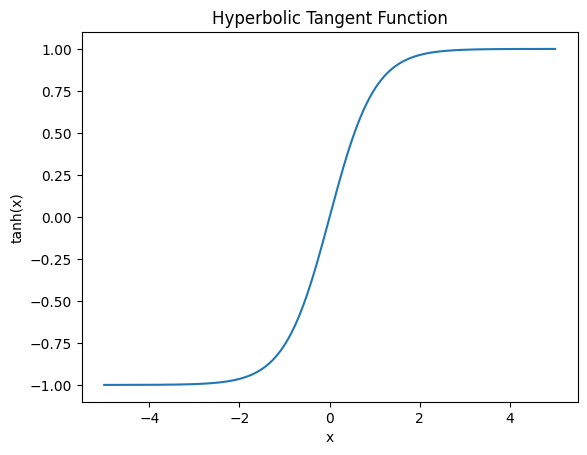

In [7]:
## Plot a tahn activation function
import numpy as np
import matplotlib.pyplot as plt

# Define the range of x-values
x = np.linspace(-5, 5, 1000)

# Calculate the y-values of the tanh function
y = np.tanh(x)

# Plot the tanh function
plt.plot(x, y)

# Add labels and a title to the plot
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('Hyperbolic Tangent Function')

# Display the plot
plt.show()

### Problem: Vanishing and Exploding Gradients

Backpropogration through time (BPTT) is a powerful algorithm that allows us to compute the gradients of the loss function with respect to the weights in the network. However, it is not without its problems. One of the most common problems is the vanishing and exploding gradients problem.

To fully understand how our neural networks are functioning, we need to delve into gradients and backpropagation. In a nutshell, backpropagation is a method of computing the gradient of the loss function with respect to the weights in the network. This is done by computing the gradient of the loss function with respect to the output of the network, and then propagating this gradient backwards through the network. We will discuss this in more detail in the following lecture.

## Implementing a RNN from scratch

To get a working understanding of RNNs, let's implement a RNN from scratch. We will work with the IMDB dataset, which contains movie reviews and their corresponding sentiment labels. The dataset contains 50,000 reviews, 25,000 of which are labeled as positive and 25,000 as negative. The dataset is split into 25,000 training and 25,000 testing reviews. We will use the training set to train our model and the testing set to evaluate its performance.

Let's begin by training a Naive Bayes on our data. We can use the performance of the Naive Bayes model as a baseline for our RNN model.

### Naive Bayes

In [13]:
## Load the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import string

from nltk.corpus import stopwords
from nltk.corpus import twitter_samples
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn import datasets

In [15]:
## load our data
df = pd.read_csv('./data/IMDB_Dataset.csv')


## clean and preprocess the data
## Let's preprocess our data
import spacy

NLP = spacy.load('en_core_web_sm')

def preprocess(text: str) -> str:
    """Preprocess by tokenizing text and remove stopwords"""
    # stopwords 
    stop_words = set(stopwords.words('english'))
    
    # tokenize the text with spacy
    doc = NLP(text)
    
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_ not in stop_words]
    return " ".join(tokens)

## Let's preprocess our data
df = df[:500].copy()
df['review'] = df['review'].apply(preprocess)
df.head()

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,positive
1,wonderful little production br film technique ...,positive
2,i think wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive


In [16]:
# create our train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

In [17]:
# Let's check the count of our train and test sets
len(X_train), len(X_val), len(y_train), len(y_val)

(400, 100, 400, 100)

In [18]:
import math

class NaiveBayesClassifier:
    def __init__(self):
        self.positive_word_counts = {}
        self.negative_word_counts = {}
        self.positive_total_count = 0
        self.negative_total_count = 0
        self.vocab = set()

    def train(self, data):
        for text, label in data:
            if label == 'positive':
                self.positive_total_count += 1
                for word in text.split():
                    self.positive_word_counts[word] = self.positive_word_counts.get(word, 0) + 1
                    self.vocab.add(word)
            elif label == 'negative':
                self.negative_total_count += 1
                for word in text.split():
                    self.negative_word_counts[word] = self.negative_word_counts.get(word, 0) + 1
                    self.vocab.add(word)

    def predict(self, text):
        # Calculate the prior probability of each class
        positive_prior = self.positive_total_count / (self.positive_total_count + self.negative_total_count + 1e-10)
        negative_prior = self.negative_total_count / (self.positive_total_count + self.negative_total_count + 1e-10)

        # Calculate the likelihood of the text given each class
        positive_likelihood = 0
        negative_likelihood = 0
        for word in text.split():
            if word in self.vocab:
                # Add Laplace smoothing to avoid zero probability
                positive_likelihood += math.log((self.positive_word_counts.get(word, 0) + 1) / (self.positive_total_count + len(self.vocab) + 1))
                negative_likelihood += math.log((self.negative_word_counts.get(word, 0) + 1) / (self.negative_total_count + len(self.vocab) + 1))

        # Calculate the posterior probability of each class
        positive_posterior = math.exp(positive_likelihood) * positive_prior
        negative_posterior = math.exp(negative_likelihood) * negative_prior

        # Return the class with the highest posterior probability
        if positive_posterior > negative_posterior:
            return 'positive'
        else:
            return 'negative'


In [19]:
## Shape our data
nb = NaiveBayesClassifier()
nb.train(zip(X_train, y_train))

In [20]:
## Test accuracy

correct_predictions = 0
total_predictions = len(X_val)

for text, label in zip(X_val, y_val):
    pred = nb.predict(text)
    if pred == label:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print('Accuracy:', accuracy)

Accuracy: 0.68


## RNNs in PyTorch

In [21]:
import torch
import torch.nn as nn
# import portalocker

In [29]:
## read the data
df = pd.read_csv('./data/IMDB_Dataset.csv')

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [30]:
# Split our data into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(40000, 10000, 40000, 10000)

In [31]:
import re
from collections import Counter, OrderedDict

token_counts = Counter()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized

for i, review in enumerate(X_train):
    tokens = tokenizer(review)
    token_counts.update(tokens)
    break

In [46]:
from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab = vocab(ordered_dict)

vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

print([vocab[token] for token in ['this', 'is', 'an', 'example']])

[26, 9, 1, 1]


In [33]:
device = torch.device("cuda:0")
# device = 'cpu'

text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: 1. if x == 'pos' else 0.


## Step 3-B: wrap the encode and transformation function
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), 
                                      dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [49]:
from torch.utils.data import DataLoader

dataloader = DataLoader(X_train, batch_size=4, shuffle=False, collate_fn=collate_batch)


# text_batch, label_batch, length_batch = next(iter(dataloader))

# text_batch, label_batch, length_batch = next(iter(dataloader))
# print(text_batch)
# print(label_batch)
# print(length_batch)
# print(text_batch.shape)

In [51]:
batch_size = 32  

train_dl = DataLoader(X_train, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(X_val, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)

In [52]:
embedding = nn.Embedding(num_embeddings=10, 
                         embedding_dim=3, 
                         padding_idx=0)
 
# a batch of 2 samples of 4 indices each
text_encoded_input = torch.LongTensor([[1,2,4,5],[4,3,2,0]])
print(embedding(text_encoded_input))

tensor([[[ 0.1991,  0.8657,  0.2444],
         [-0.6629,  0.8073,  1.1017],
         [ 0.0612, -0.6177,  0.7312],
         [ 1.1718, -0.9274,  0.5451]],

        [[ 0.0612, -0.6177,  0.7312],
         [-0.1759, -2.2456, -1.4465],
         [-0.6629,  0.8073,  1.1017],
         [ 0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)


In [53]:
## An example of building a RNN model
## with simple RNN layer

# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, 
                          hidden_size, 
                          num_layers=2, 
                          batch_first=True)
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        _, hidden = self.rnn(x)
        out = hidden[-1, :, :]
        out = self.fc(out)
        return out

model = RNN(64, 32) 

print(model) 
 
model(torch.randn(5, 3, 64)) 

RNN(
  (rnn): RNN(64, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


tensor([[-0.2122],
        [-0.2387],
        [ 0.2438],
        [-0.1354],
        [-0.4309]], grad_fn=<AddmmBackward0>)

In [54]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
         
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)

In [55]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)
 
def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

In [56]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10 

torch.manual_seed(1)
 
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')
 

KeyError: 4894

# Resources (Continued Reading)

* [Andrej Karpathy's blog post on word embeddings](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [A Visual Introduction to Word Embeddings](https://jalammar.github.io/illustrated-word2vec/)
* [A Visual Introduction to Machine Learning](https://jalammar.github.io/visual-interactive-guide-basics-machine-learning-algorithms/)